# Phần 1: Chọn mô hình

## 1.Import các thư viện cần thiết

In [55]:
# !pip install pandas numpy matplotlib seaborn lifetimes scikit-learn xgboost tqdm
# !pip install lifetimes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, average_precision_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi']=120

## 2.Tải lên các bảng dữ liệu

In [56]:
customers = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_customers_dataset.csv")
orders = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_orders_dataset.csv")
items = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_order_items_dataset.csv")
payments = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_order_payments_dataset.csv")
reviews = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_order_reviews_dataset.csv")

In [57]:
# Kiểm tra kích thước và cột
print(customers.shape, orders.shape, items.shape, payments.shape, reviews.shape)
orders.head(3)

(99441, 5) (99441, 8) (112650, 7) (103886, 5) (99224, 7)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


### 2.1. Table orders

In [58]:
orders.head(4)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00


In [59]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


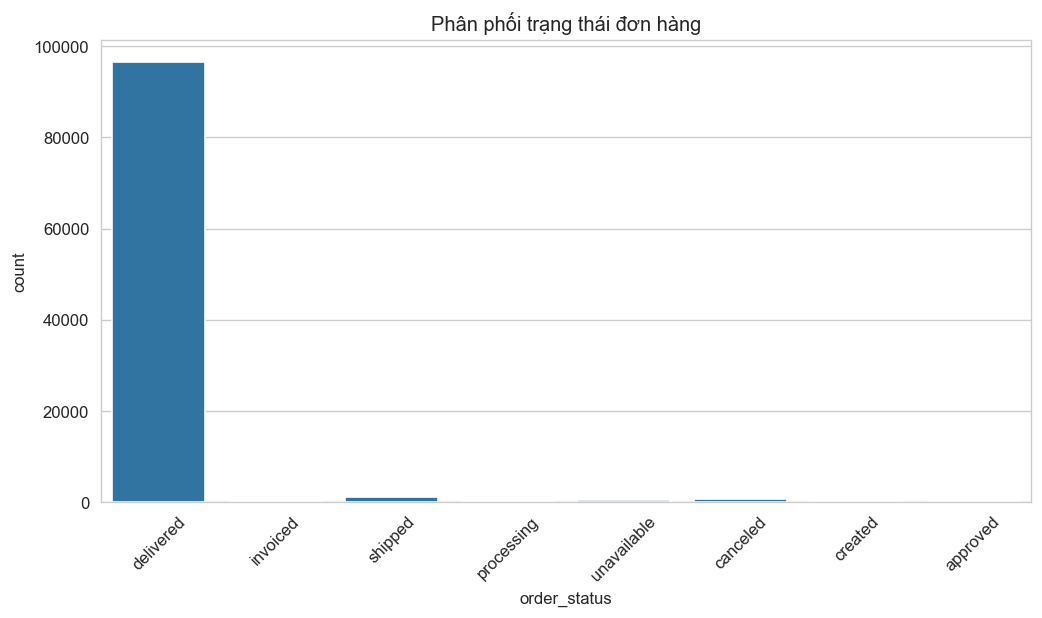

In [60]:
# Phân tích trạng thái đơn hàng
plt.figure(figsize=(10, 5))
sns.countplot(data=orders, x='order_status')
plt.title("Phân phối trạng thái đơn hàng")
plt.xticks(rotation=45)
plt.show()

In [61]:
#Tạo funtion để tính tỉ lệ giá trị bị null trong các hàng
def calc_null_rate(df):
  newdf=df.isnull().sum().to_frame('null_count')
  newdf[['null_rate']]=newdf[['null_count']]/len(df)
  return newdf.sort_values(by=['null_rate'],ascending=False)

In [62]:
calc_null_rate(orders)

,null_count,null_rate
order_delivered_customer_date,2965,0.029817
order_delivered_carrier_date,1783,0.017930
order_approved_at,160,0.001609
order_id,0,0.000000
order_purchase_timestamp,0,0.000000
order_status,0,0.000000
customer_id,0,0.000000
order_estimated_delivery_date,0,0.000000


* Nhận xét: 3 cột đầu tiên có giá trị null nhưng phần phân tích phía dưới không dùng nên sẽ lược bỏ

In [63]:
orders['order_status'].value_counts(normalize=True) * 100

order_status
delivered      97.020344
shipped         1.113223
canceled        0.628513
unavailable     0.612423
invoiced        0.315765
processing      0.302692
created         0.005028
approved        0.002011
Name: proportion, dtype: float64

* Lưu ý: Ở phần phân tích phía sau, chỉ giữ lại các đơn hàng đã có trạng thái chuyển "delivered"

### 2.2. Table items

In [64]:
items.head(4)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79


In [65]:
items.head(4)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79


In [66]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [67]:
calc_null_rate(items)

,null_count,null_rate
order_id,0,0.0
order_item_id,0,0.0
product_id,0,0.0
seller_id,0,0.0
shipping_limit_date,0,0.0
price,0,0.0
freight_value,0,0.0


In [68]:
items['order_id'].nunique()

98666

Nhận xét: Vì mỗi đơn hàng có nhiều order_item khác nhau

In [69]:
items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


+ Nhận xét: Cột price và freight value không xuất hiện giá trị âm => Phù hợp

In [70]:
# Kiểm tra tỷ lệ freight_value = 0
zero_freight = (items['freight_value'] == 0).sum()
total_rows = len(items)
print(f"Số dòng freight_value = 0: {zero_freight} ({zero_freight/total_rows*100:.2f}%)")

Số dòng freight_value = 0: 383 (0.34%)


+ Nhận xét: Có thể đây là những đơn hàng freeship nên giá trị vận chuyển = 0 là bình thường (Không loại bỏ)

### 2.3. Table customers

In [71]:
customers.head(4)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP


In [72]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [73]:
customers['customer_id'].nunique()

99441

In [74]:
customers['customer_unique_id'].nunique()

96096

* Nhận xét: Có 99,441 đơn hàng được gán cho 96,096 khách hàng thực tế
  → Tức là chỉ khoảng 3,345 khách hàng đã mua từ 2 lần trở lên

In [75]:
repeat_customers = (
    customers.groupby('customer_unique_id')['customer_id']
    .nunique()
    .reset_index(name='order_count')
)

repeat_customers['is_repeat'] = repeat_customers['order_count'] > 1
repeat_customers['is_repeat'].value_counts(normalize=True) * 100

is_repeat
False    96.881244
True      3.118756
Name: proportion, dtype: float64

* Nhận xét: Nghĩa là khoảng 3.12% khách hàng thực đã mua nhiều hơn 1 lần và gần 97% khách hàng chỉ mua 1 lần duy nhất

In [76]:
# In ra số khách hàng ở mỗi tháng

orders_cust = orders.merge(customers, on='customer_id', how='left')

# Chuyển cột thời gian sang datetime
orders_cust['order_date'] = pd.to_datetime(orders_cust['order_purchase_timestamp'])

# Tạo cột tháng
orders_cust['order_month'] = orders_cust['order_date'].dt.to_period('M')

# Tính số khách hàng unique mỗi tháng (dựa trên customer_unique_id)
unique_users_by_month = (
    orders_cust.groupby('order_month')['customer_unique_id']
    .nunique()
    .reset_index()
    .rename(columns={'customer_unique_id': 'n_unique_users'})
)

# Chuyển order_month về dạng timestamp
unique_users_by_month['order_month'] = unique_users_by_month['order_month'].dt.to_timestamp()

print(unique_users_by_month.head(30))

   order_month  n_unique_users
0   2016-09-01               4
1   2016-10-01             321
2   2016-12-01               1
3   2017-01-01             765
4   2017-02-01            1755
5   2017-03-01            2642
6   2017-04-01            2372
7   2017-05-01            3625
8   2017-06-01            3180
9   2017-07-01            3947
10  2017-08-01            4246
11  2017-09-01            4212
12  2017-10-01            4561
13  2017-11-01            7430
14  2017-12-01            5603
15  2018-01-01            7166
16  2018-02-01            6569
17  2018-03-01            7115
18  2018-04-01            6882
19  2018-05-01            6814
20  2018-06-01            6128
21  2018-07-01            6230
22  2018-08-01            6460
23  2018-09-01              14
24  2018-10-01               4


* Nhận xét: Mặc dù Dataset từ 9/2016 - 10/2018, tuy nhiên bị thiếu dữ liệu của tháng 11/2016, đồng thời số khách hàng của tháng 9,10,12 năm 2016 và tháng 9,10 của năm 2018 rất nhỏ
  * Vì thế, bài phân tích chỉ tập trung vào khoảng 1/2017 đến 6/2018

## 3.Gộp bảng và lọc điều kiện

In [77]:
# Giữ đơn đã giao thành công (orderorder_status là delivered)
orders = orders[orders['order_status'] == 'delivered'].copy()
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')

# Tính giá trị đơn hàng = price + freight_value 
items['order_value'] = items['price'] + items['freight_value']
order_val = items.groupby('order_id', as_index=False)['order_value'].sum()

# Merge bảng giao dịch 
trans = (
    orders[['order_id', 'customer_id', 'order_purchase_timestamp']]
    .merge(order_val, on='order_id', how='left')
    .merge(customers[['customer_id', 'customer_unique_id', 'customer_state']], on='customer_id', how='left')
    .rename(columns={'order_purchase_timestamp': 'order_date'})
    [['order_id', 'customer_unique_id', 'order_date', 'order_value', 'customer_state']]
    .dropna()
    .drop_duplicates()
)
trans['order_date'] = pd.to_datetime(trans['order_date'], errors='coerce')

# Chỉ giữ lại dữ liệu từ 01/01/2017 trở đi
trans = trans[trans['order_date'] >= '2017-01-01']
print("Tổng số giao dịch:", len(trans))
trans.head(3)


Tổng số giao dịch: 96211


,order_id,customer_unique_id,order_date,order_value,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,38.71,SP
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,141.46,BA
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,179.12,GO


In [78]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96211 entries, 0 to 96477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            96211 non-null  object        
 1   customer_unique_id  96211 non-null  object        
 2   order_date          96211 non-null  datetime64[ns]
 3   order_value         96211 non-null  float64       
 4   customer_state      96211 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 4.4+ MB


In [79]:
calc_null_rate(trans)

,null_count,null_rate
order_id,0,0.0
customer_unique_id,0,0.0
order_date,0,0.0
order_value,0,0.0
customer_state,0,0.0


## 4.EDA (phân phối & đặc điểm dữ liệu)

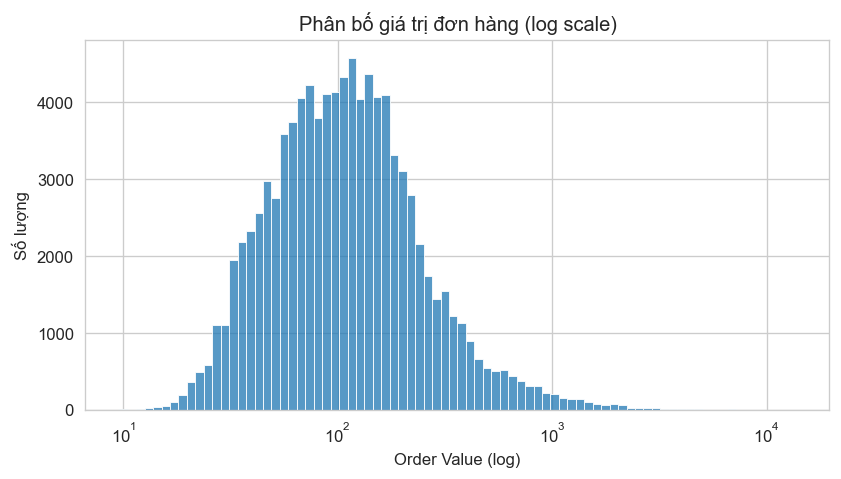

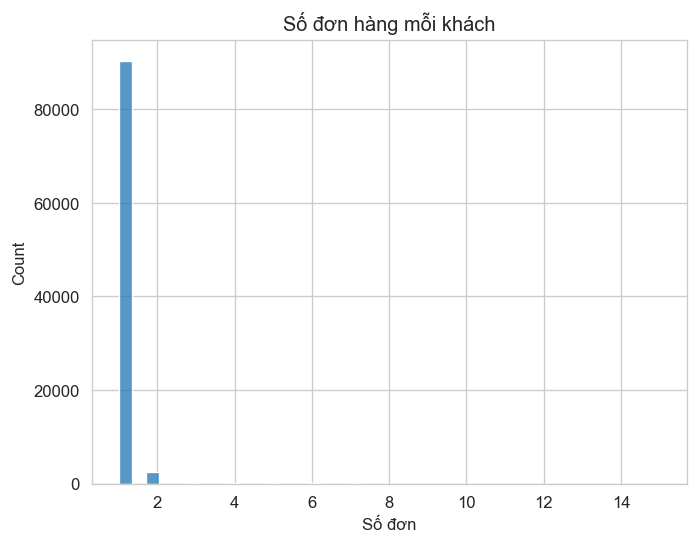

Tỷ lệ khách chỉ mua 1 lần: 97.0 %


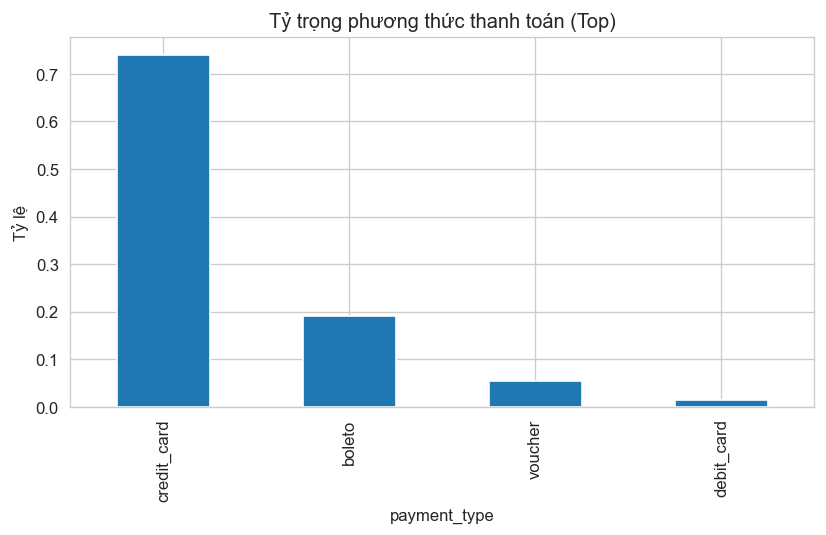

In [80]:
plt.figure(figsize=(8,4))
sns.histplot(trans['order_value'], bins=80, log_scale=True)
plt.title("Phân bố giá trị đơn hàng (log scale)")
plt.xlabel("Order Value (log)")
plt.ylabel("Số lượng"); plt.show()

# Phân phối số đơn theo khách
cust_orders = trans.groupby('customer_unique_id')['order_id'].nunique()
sns.histplot(cust_orders, bins=40)
plt.title("Số đơn hàng mỗi khách"); plt.xlabel("Số đơn"); plt.show()
print("Tỷ lệ khách chỉ mua 1 lần:", (cust_orders.eq(1).mean()*100).round(2), "%")

# Tỷ trọng phương thức thanh toán
pm = payments.merge(orders[['order_id']], on='order_id', how='inner')
share = pm['payment_type'].value_counts(normalize=True).head(6)
share.plot(kind='bar', figsize=(8,4))
plt.title("Tỷ trọng phương thức thanh toán (Top)"); plt.ylabel("Tỷ lệ"); plt.show()


## 5.Tách thời gian (Cutoff & Horizon) + Chia Train/Test

Train orders: 43357 | Test (horizon): 40344


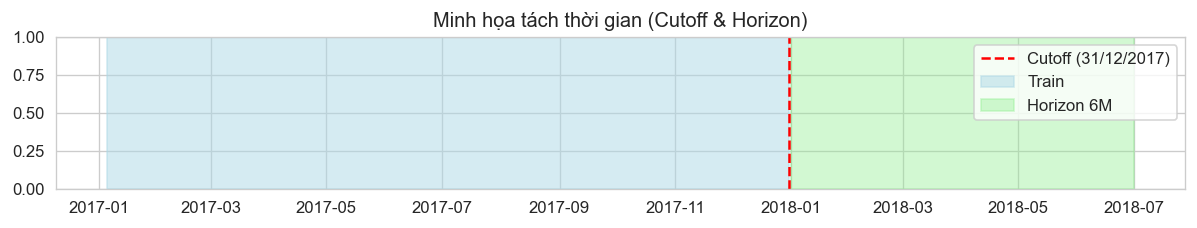

In [81]:
# Thiết lập mốc thời gian tách dữ liệu (temporal split)

# Trong đó:
# - CUTOFF: mốc tách train/test (31/12/2017)
# - H_START, H_END: giai đoạn dự báo CLV (01/2018–06/2018)
# - SNAPSHOT: điểm tham chiếu tính Recency

CUTOFF  = pd.Timestamp('2017-12-31')
H_START = CUTOFF + pd.Timedelta(days=1)
H_END   = H_START + pd.DateOffset(months=6)
SNAPSHOT = CUTOFF + pd.Timedelta(days=1)

# Chia dữ liệu:
# - train_tx: giao dịch trước cutoff (dùng huấn luyện)
# - test_tx : giao dịch sau cutoff (dùng đánh giá CLV thực tế)
train_tx = trans[trans['order_date'] <= CUTOFF].copy()
test_tx  = trans[(trans['order_date'] > CUTOFF) & (trans['order_date'] <= H_END)].copy()

# Lưu ý: Khách hàng chỉ xuất hiện sau cutoff (cold-start) sẽ bị loại tự động
# vì không có lịch sử trong train_tx → không thể dự báo CLV
print("Train orders:", len(train_tx), "| Test (horizon):", len(test_tx))

# Chart Cutoff & Horizon
plt.figure(figsize=(10,2))
plt.axvline(CUTOFF, color='r', linestyle='--', label='Cutoff (31/12/2017)')
plt.axvspan(train_tx['order_date'].min(), CUTOFF, color='lightblue', alpha=0.5, label='Train')
plt.axvspan(H_START, H_END, color='lightgreen', alpha=0.4, label='Horizon 6M')
plt.title("Minh họa tách thời gian (Cutoff & Horizon)")
plt.legend(); plt.tight_layout(); plt.show()


In [82]:
train_tx['customer_unique_id'].nunique()

42066

In [83]:
train_tx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43357 entries, 0 to 96475
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            43357 non-null  object        
 1   customer_unique_id  43357 non-null  object        
 2   order_date          43357 non-null  datetime64[ns]
 3   order_value         43357 non-null  float64       
 4   customer_state      43357 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.0+ MB


## 6.Tính RFM (Recency–Frequency–Monetary)

In [84]:
rfm_simple = (
    train_tx.groupby('customer_unique_id')
    .agg(last=('order_date', 'max'),
         first=('order_date', 'min'),
         num=('order_id', 'nunique'),
         spent=('order_value', 'sum'))
)

rfm_simple['recency']   = (SNAPSHOT - rfm_simple['last']).dt.days
rfm_simple['T']         = (SNAPSHOT - rfm_simple['first']).dt.days
rfm_simple['frequency'] = rfm_simple['num']      # không trừ 1
rfm_simple['monetary']  = rfm_simple['spent'] / rfm_simple['num']

rfm_simple = rfm_simple[['recency', 'frequency', 'T', 'monetary']].reset_index()
rfm_simple.head(10)

,customer_unique_id,recency,frequency,T,monetary
0,0000f46a3911fa3c0805444483337064,296,1,296,86.22
1,0000f6ccb0745a6a4b88665a16c9f078,80,1,80,43.62
2,0004aac84e0df4da2b147fca70cf8255,47,1,47,196.89
3,0005e1862207bf6ccc02e4228effd9a0,302,1,302,150.12
4,0006fdc98a402fceb4eb0ee528f6a8d4,166,1,166,29.00
5,00082cbe03e478190aadbea78542e933,42,1,42,126.26
6,000a5ad9c4601d2bbdd9ed765d5213b3,142,1,142,91.28
7,000bfa1d2f1a41876493be685390d6d3,93,1,93,46.85
8,000c8bdb58a29e7115cfc257230fb21b,19,1,19,29.00
9,000de6019bb59f34c099a907c151d855,136,1,136,257.44


In [85]:
rfm_simple.describe()

,recency,frequency,T,monetary
count,42066.000000,42066.000000,42066.000000,42066.000000
mean,136.727571,1.030690,137.985428,159.910345
std,95.225645,0.194258,95.428196,226.197880
min,1.000000,1.000000,1.000000,10.070000
25%,47.000000,1.000000,48.000000,62.010000
50%,122.000000,1.000000,124.000000,104.190000
75%,212.000000,1.000000,214.000000,175.550000
max,360.000000,8.000000,360.000000,13664.080000


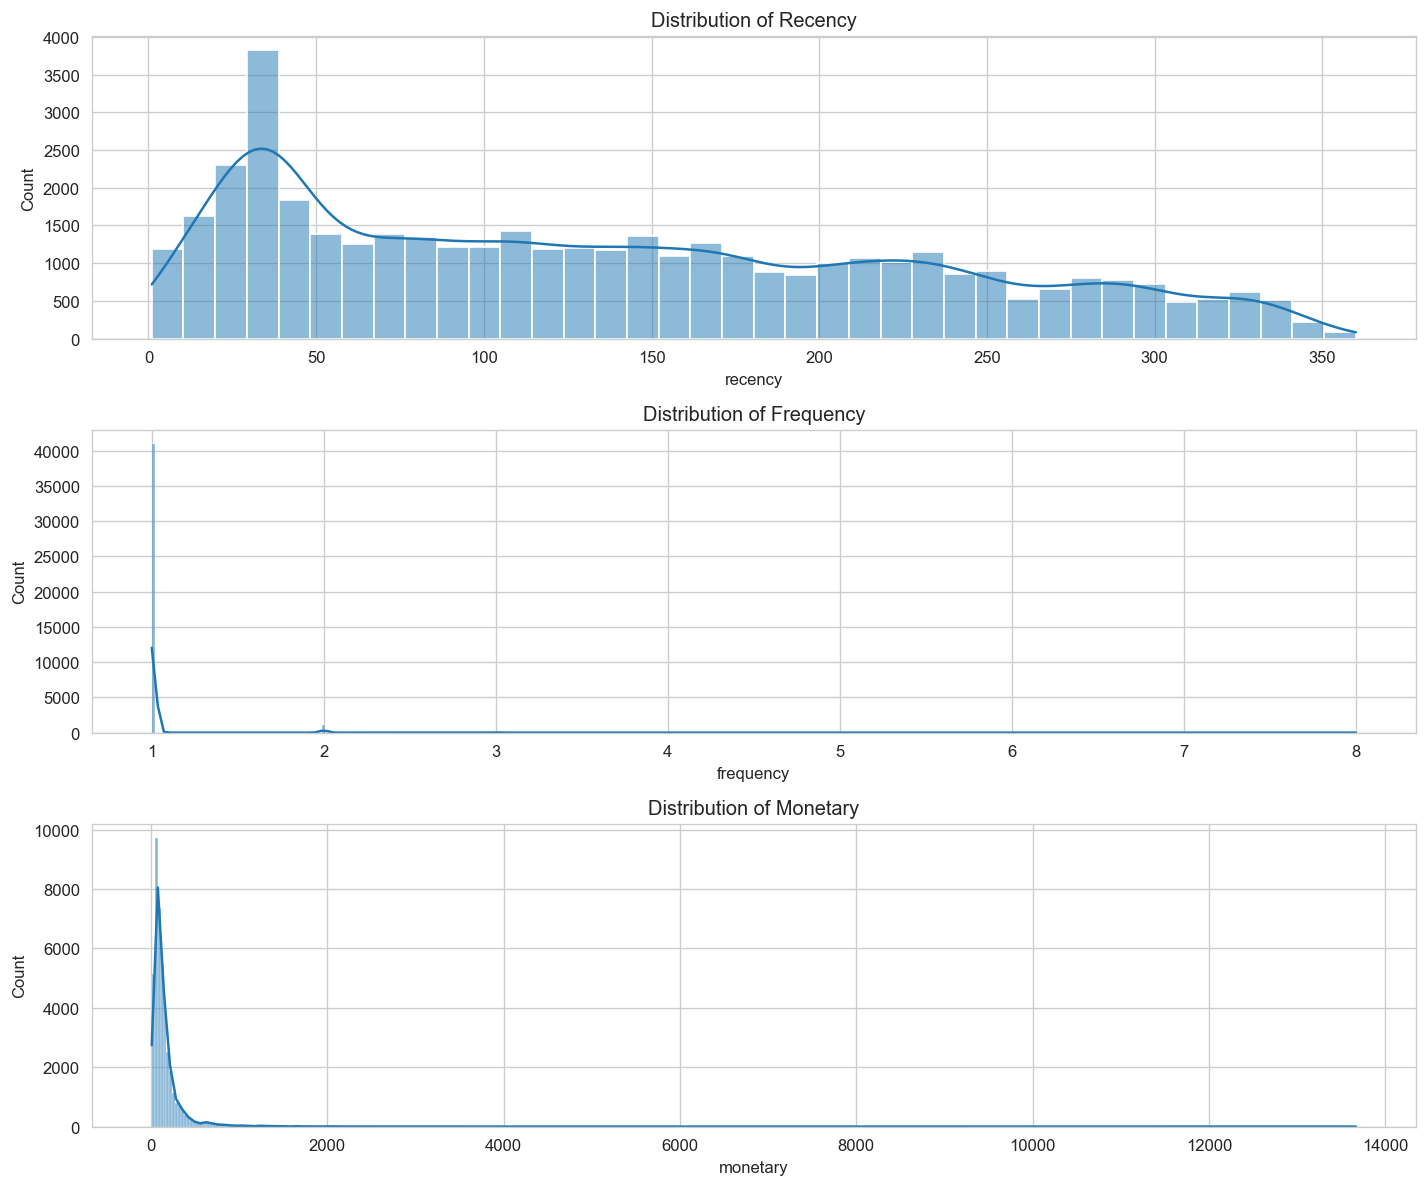

In [86]:
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
sns.histplot(rfm_simple['recency'], kde=True)
plt.title('Distribution of Recency')

plt.subplot(3, 1, 2)
sns.histplot(rfm_simple['frequency'], kde=True)
plt.title('Distribution of Frequency')

plt.subplot(3, 1, 3)
sns.histplot(rfm_simple['monetary'], kde=True)
plt.title('Distribution of Monetary')

plt.tight_layout()
plt.show()


## 7.Cohort Retention

In [87]:
train_tx['order_month'] = train_tx['order_date'].dt.to_period('M')
first_month = train_tx.groupby('customer_unique_id')['order_month'].min().rename('cohort')
cohort_df = train_tx.merge(first_month, on='customer_unique_id', how='left')
cohort_df['cohort_index'] = (cohort_df['order_month'] - cohort_df['cohort']).apply(lambda p: p.n)

cohort_pivot = (
    cohort_df.groupby(['cohort', 'cohort_index'])['customer_unique_id']
    .nunique().unstack(1).fillna(0)
)
retention = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)


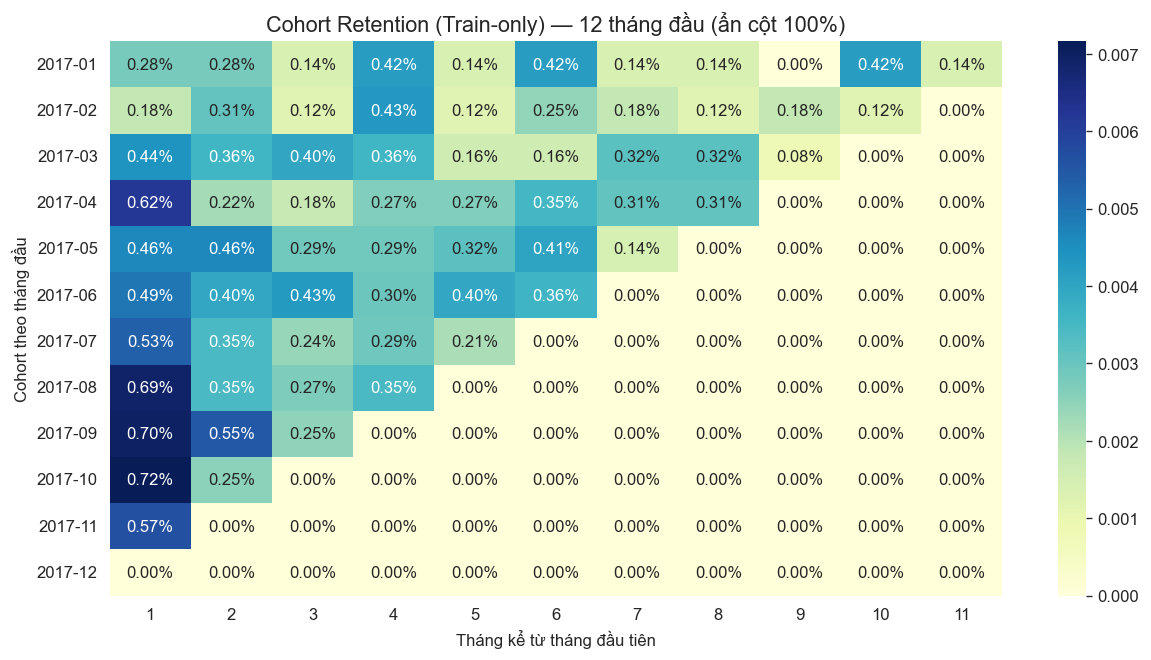

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Bỏ cột 0 (tháng đầu = 100%)
sns.heatmap(
    retention.iloc[:, 1:13],    # chỉ lấy từ tháng 1 đến tháng 12
    annot=True,
    fmt=".2%",
    cmap="YlGnBu",
    cbar=True
)

plt.title("Cohort Retention (Train-only) — 12 tháng đầu (ẩn cột 100%)", fontsize=13)
plt.ylabel("Cohort theo tháng đầu")
plt.xlabel("Tháng kể từ tháng đầu tiên")
plt.show()


* Nhận xét tổng quan:
  - Tỷ lệ quay lại nhìn chung rất thấp, chỉ dao động quanh 0.2–0.7% ở tháng kế tiếp, rồi giảm nhanh về gần 0% sau 3–4 tháng.

  - Đa số cohort đều có hiện tượng “rơi rụng nhanh”, đặc biệt từ tháng thứ 4 trở đi, gần như không còn khách quay lại.

  - Điều này cho thấy phần lớn khách hàng chỉ phát sinh một lần mua, đúng với mô tả “one-time heavy” thường thấy trong thương mại điện tử marketplace.

## 8.Baseline CLV – Fit BG/NBD & Gamma–Gamma

### 8.1. Dự báo CLV

In [89]:
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

# Tạo bảng tóm tắt hành vi mua (input cho lifetimes)
summary = summary_data_from_transaction_data(
    transactions=train_tx,
    customer_id_col='customer_unique_id',
    datetime_col='order_date',
    monetary_value_col='order_value',
    observation_period_end=SNAPSHOT,
    freq='D'
).reset_index()
summary.head(5)

,customer_unique_id,frequency,recency,T,monetary_value
0,0000f46a3911fa3c0805444483337064,0.0,0.0,297.0,0.0
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,81.0,0.0
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,48.0,0.0
3,0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,303.0,0.0
4,0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,167.0,0.0


In [90]:
summary.describe()

,frequency,recency,T,monetary_value
count,42066.000000,42066.000000,42066.000000,42066.000000
mean,0.018423,1.257857,138.985428,2.518800
std,0.150337,13.306687,95.428196,28.648989
min,0.000000,0.000000,2.000000,0.000000
25%,0.000000,0.000000,49.000000,0.000000
50%,0.000000,0.000000,125.000000,0.000000
75%,0.000000,0.000000,215.000000,0.000000
max,7.000000,313.000000,361.000000,1650.180000


In [91]:
# Fit mô hình BG/NBD (tần suất mua)
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Fit mô hình Gamma–Gamma (chi tiêu trung bình)
mask_rep = (summary['frequency'] > 0) & (summary['monetary_value'] > 0)
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(summary.loc[mask_rep,'frequency'], summary.loc[mask_rep,'monetary_value'])

# Dự báo số lần mua và chi tiêu trong 6 tháng tới
H_days = (H_END - H_START).days + 1
summary['pred_purchases_6m'] = bgf.predict(H_days, summary['frequency'], summary['recency'], summary['T'])
summary['pred_avg_value']    = ggf.conditional_expected_average_profit(summary['frequency'], summary['monetary_value'])
summary['CLV_prob_6m']       = summary['pred_purchases_6m'] * summary['pred_avg_value']

# Xác suất còn hoạt động
summary['p_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])

summary.head(10)

,customer_unique_id,frequency,recency,T,monetary_value,pred_purchases_6m,pred_avg_value,CLV_prob_6m,p_alive
0,0000f46a3911fa3c0805444483337064,0.0,0.0,297.0,0.0,0.006591,280.695271,1.850148,1.0
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,81.0,0.0,0.013880,280.695271,3.895925,1.0
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,48.0,0.0,0.016867,280.695271,4.734350,1.0
3,0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,303.0,0.0,0.006498,280.695271,1.823989,1.0
4,0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,167.0,0.0,0.009594,280.695271,2.693117,1.0
5,00082cbe03e478190aadbea78542e933,0.0,0.0,43.0,0.0,0.017446,280.695271,4.897041,1.0
6,000a5ad9c4601d2bbdd9ed765d5213b3,0.0,0.0,143.0,0.0,0.010488,280.695271,2.944016,1.0
7,000bfa1d2f1a41876493be685390d6d3,0.0,0.0,94.0,0.0,0.012989,280.695271,3.645888,1.0
8,000c8bdb58a29e7115cfc257230fb21b,0.0,0.0,20.0,0.0,0.020802,280.695271,5.839017,1.0
9,000de6019bb59f34c099a907c151d855,0.0,0.0,137.0,0.0,0.010739,280.695271,3.014516,1.0


In [92]:
# In thống kê mô tả cho 3 biến chính
summary[['pred_purchases_6m', 'pred_avg_value', 'p_alive']].describe().T

,count,mean,std,min,25%,50%,75%,max
pred_purchases_6m,42066.0,0.014917,0.052763,0.005718,0.008281,0.011426,0.017093,5.098224
pred_avg_value,42066.0,278.553764,26.255819,22.907304,280.695271,280.695271,280.695271,1604.838045
p_alive,42066.0,0.985326,0.113702,0.025294,1.000000,1.000000,1.000000,1.000000


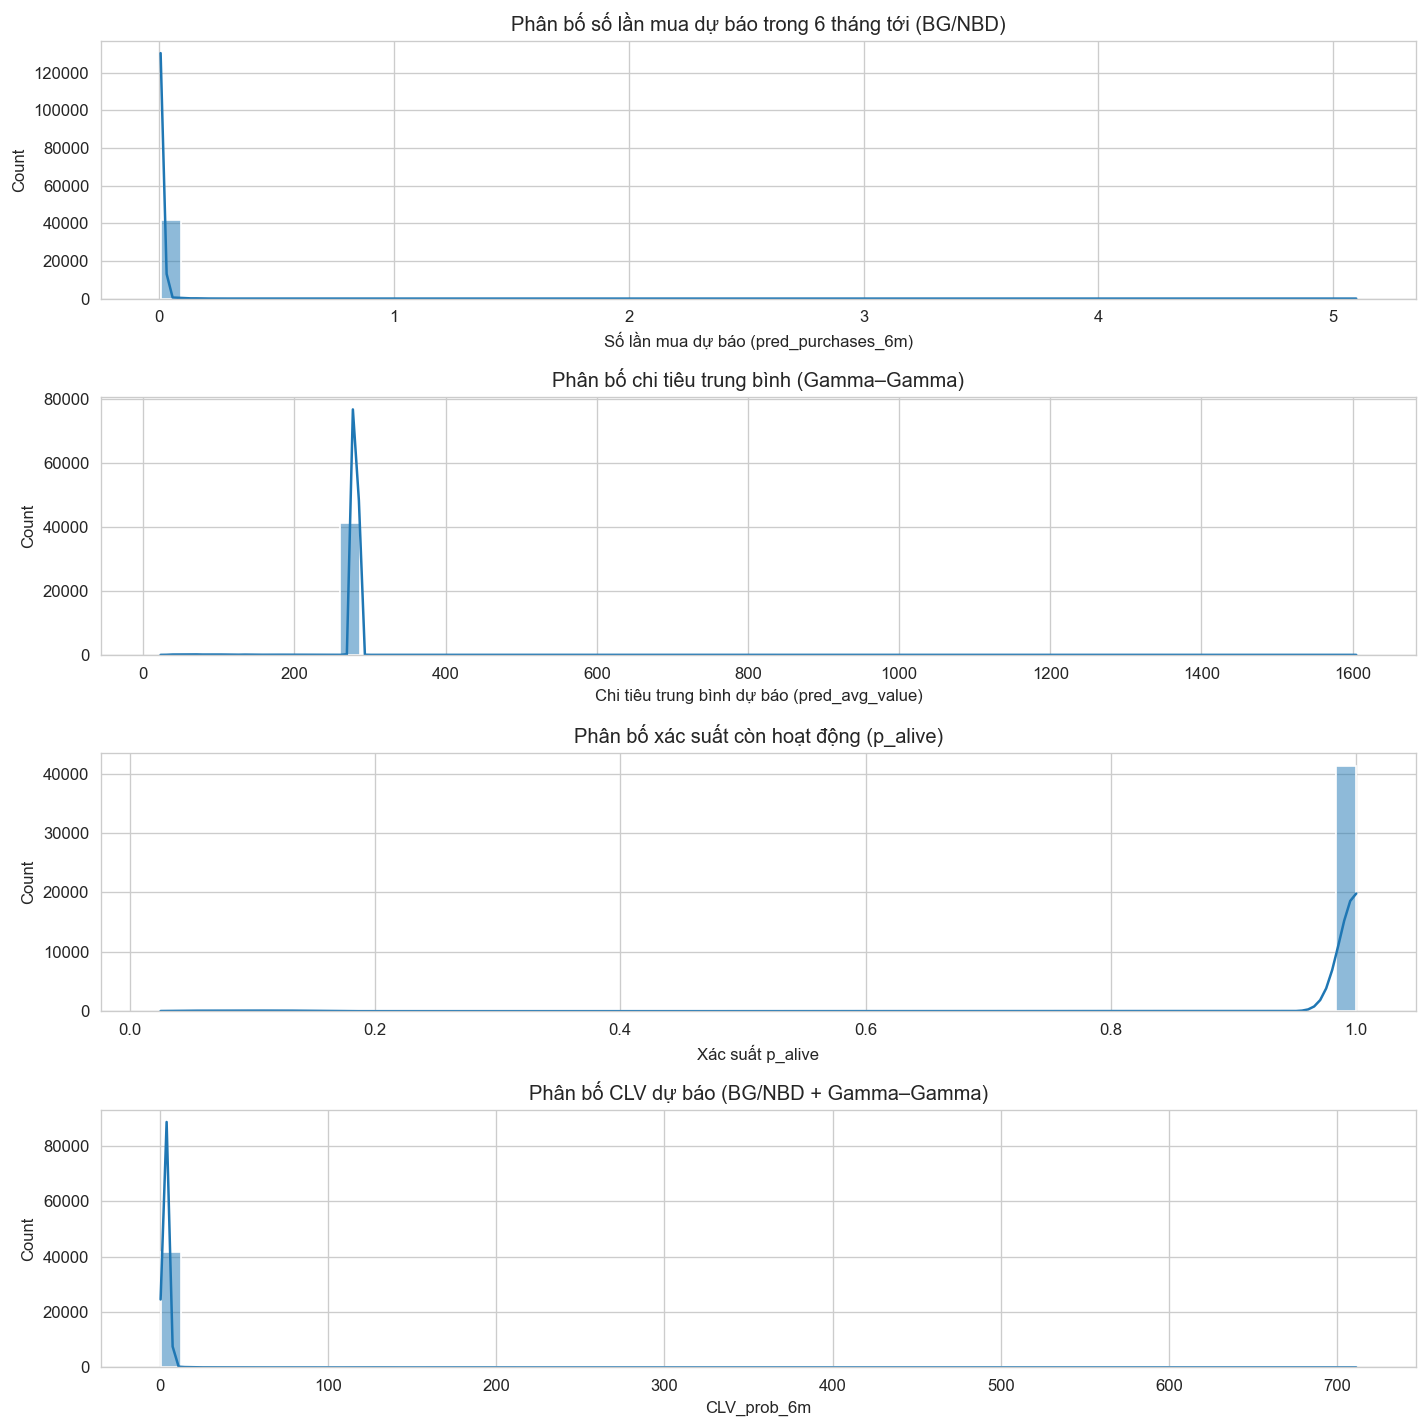

In [93]:
plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
sns.histplot(summary['pred_purchases_6m'], kde=True, bins=60)
plt.title('Phân bố số lần mua dự báo trong 6 tháng tới (BG/NBD)')
plt.xlabel('Số lần mua dự báo (pred_purchases_6m)')

plt.subplot(4, 1, 2)
sns.histplot(summary['pred_avg_value'], kde=True, bins=60)
plt.title('Phân bố chi tiêu trung bình (Gamma–Gamma)')
plt.xlabel('Chi tiêu trung bình dự báo (pred_avg_value)')

plt.subplot(4, 1, 3)
sns.histplot(summary['p_alive'], kde=True, bins=60)
plt.title('Phân bố xác suất còn hoạt động (p_alive)')
plt.xlabel('Xác suất p_alive')

plt.subplot(4, 1, 4)
sns.histplot(summary['CLV_prob_6m'], kde=True, bins=60)
plt.title('Phân bố CLV dự báo (BG/NBD + Gamma–Gamma)')
plt.xlabel('CLV_prob_6m')

plt.tight_layout()
plt.show()


* Nhận xét:
  - Phân phối CLV dự báo (BG/NBD + Gamma–Gamma) cho thấy giá trị rất lệch phải, phần lớn khách hàng có CLV thấp trong khi chỉ một số ít có giá trị cao vượt trội --> Phản ánh sự tập trung giá trị trong nhóm nhỏ khách hàng

### 8.2. CALIBRATION DECILE
* Dùng để đánh giá độ tin cậy của toàn bộ mô hình xác suất (BG/NBD + GG)

In [94]:
from lifetimes.utils import calibration_and_holdout_data

cal_hold_df = calibration_and_holdout_data(
    transactions=trans,
    customer_id_col='customer_unique_id',
    datetime_col='order_date',
    calibration_period_end=CUTOFF,
    observation_period_end=H_END,
    freq='D'
)

In [95]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(
    frequency=cal_hold_df['frequency_cal'],
    recency=cal_hold_df['recency_cal'],
    T=cal_hold_df['T_cal']
)

<lifetimes.BetaGeoFitter: fitted with 42066 subjects, a: 0.26, alpha: 57.39, b: 0.05, r: 0.02>

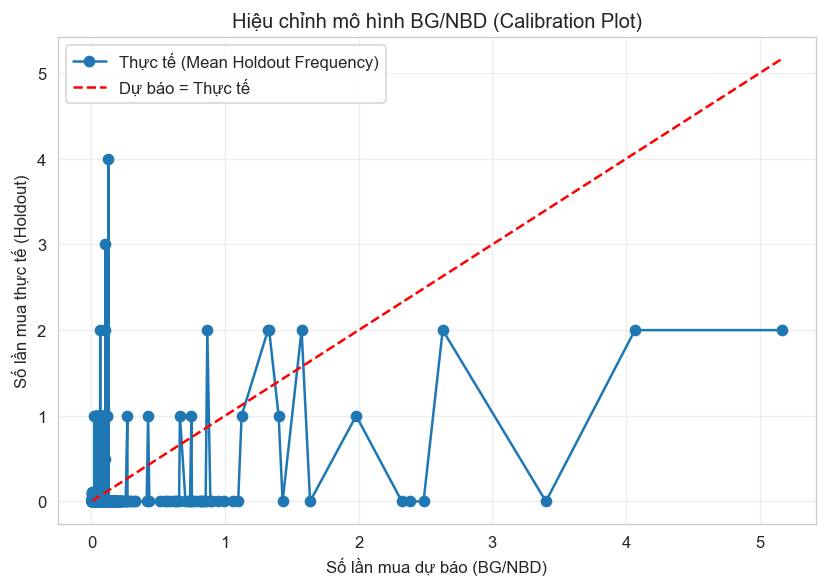

In [96]:
# Dự báo số lần mua trong giai đoạn holdout

t_holdout = cal_hold_df['duration_holdout'].iloc[0]  # số ngày holdout
cal_hold_df['pred_purchases'] = bgf.predict(
    t=t_holdout,
    frequency=cal_hold_df['frequency_cal'],
    recency=cal_hold_df['recency_cal'],
    T=cal_hold_df['T_cal']
)

# Gom theo số lần mua dự báo
grouped = cal_hold_df.groupby('pred_purchases')['frequency_holdout'].mean()

# Vẽ biểu đồ calibration
plt.figure(figsize=(7, 5))
plt.plot(grouped.index, grouped.values, "o-", label="Thực tế (Mean Holdout Frequency)")
plt.plot(grouped.index, grouped.index, "r--", label="Dự báo = Thực tế")
plt.title("Hiệu chỉnh mô hình BG/NBD (Calibration Plot)")
plt.xlabel("Số lần mua dự báo (BG/NBD)")
plt.ylabel("Số lần mua thực tế (Holdout)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 9.Gắn nhãn CLV thực tế & tạo Feature Set

In [97]:
# Nhãn thật (chi tiêu thực tế trong Horizon) - Horizon là 6 tháng đầu của 2018
y_true = (
    test_tx.groupby('customer_unique_id')['order_value'].sum()
    .rename('CLV_actual_6m')
)
summary = summary.merge(y_true, on='customer_unique_id', how='left')
summary['CLV_actual_6m'] = summary['CLV_actual_6m'].fillna(0.0)

In [98]:
print("10 hàng đầu tiên của bảng summary với CLV_actual_6m:")
print(summary[['customer_unique_id', 'frequency', 'recency', 'T', 'CLV_actual_6m']].head(10))

print("\nThống kê mô tả (describe) của CLV_actual_6m:")
print(summary['CLV_actual_6m'].describe())

10 hàng đầu tiên của bảng summary với CLV_actual_6m:
                 customer_unique_id  frequency  recency      T  CLV_actual_6m
0  0000f46a3911fa3c0805444483337064        0.0      0.0  297.0            0.0
1  0000f6ccb0745a6a4b88665a16c9f078        0.0      0.0   81.0            0.0
2  0004aac84e0df4da2b147fca70cf8255        0.0      0.0   48.0            0.0
3  0005e1862207bf6ccc02e4228effd9a0        0.0      0.0  303.0            0.0
4  0006fdc98a402fceb4eb0ee528f6a8d4        0.0      0.0  167.0            0.0
5  00082cbe03e478190aadbea78542e933        0.0      0.0   43.0            0.0
6  000a5ad9c4601d2bbdd9ed765d5213b3        0.0      0.0  143.0            0.0
7  000bfa1d2f1a41876493be685390d6d3        0.0      0.0   94.0            0.0
8  000c8bdb58a29e7115cfc257230fb21b        0.0      0.0   20.0            0.0
9  000de6019bb59f34c099a907c151d855        0.0      0.0  137.0            0.0

Thống kê mô tả (describe) của CLV_actual_6m:
count    42066.000000
mean         2.007218

In [99]:
# Đếm số lượng CLV = 0 (kiểm tra Zero-Inflation)
zero_clv = (summary['CLV_actual_6m'] == 0).sum()
total_cust = len(summary)
print(f"\nTỷ lệ khách hàng có CLV_actual_6m = 0: {zero_clv / total_cust * 100:.2f}% ({zero_clv}/{total_cust})")


Tỷ lệ khách hàng có CLV_actual_6m = 0: 98.73% (41530/42066)


In [100]:
# Bổ sung feature hành vi mở rộng (payment/review/items)
agg_base = train_tx[['order_id','customer_unique_id','customer_state']].copy()
feat_aggs = (
    agg_base
    .merge(payments[['order_id','payment_value']], on='order_id', how='left')
    .merge(reviews[['order_id','review_score']], on='order_id', how='left')
    .merge(items[['order_id','product_id']], on='order_id', how='left')
    .groupby('customer_unique_id')
    .agg(
        payment_value_sum   = ('payment_value','sum'),
        payment_value_mean  = ('payment_value','mean'),
        review_score_mean   = ('review_score','mean'),
        num_unique_products = ('product_id', pd.Series.nunique),
        state_mode          = ('customer_state', lambda x: x.mode()[0] if len(x.mode())>0 else np.nan)
    ).reset_index()
)

# Merge features vào bảng summary
summary_ml = summary.merge(feat_aggs, on='customer_unique_id', how='left')
summary_ml.head(5)

,customer_unique_id,frequency,recency,T,monetary_value,pred_purchases_6m,pred_avg_value,CLV_prob_6m,p_alive,CLV_actual_6m,payment_value_sum,payment_value_mean,review_score_mean,num_unique_products,state_mode
0,0000f46a3911fa3c0805444483337064,0.0,0.0,297.0,0.0,0.006591,280.695271,1.850148,1.0,0.0,86.22,86.22,3.0,1,SC
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,81.0,0.0,0.013880,280.695271,3.895925,1.0,0.0,43.62,43.62,4.0,1,PA
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,48.0,0.0,0.016867,280.695271,4.734350,1.0,0.0,196.89,196.89,5.0,1,SP
3,0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,303.0,0.0,0.006498,280.695271,1.823989,1.0,0.0,150.12,150.12,4.0,1,RJ
4,0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,167.0,0.0,0.009594,280.695271,2.693117,1.0,0.0,29.00,29.00,3.0,1,ES


In [101]:
calc_null_rate(summary_ml)

,null_count,null_rate
review_score_mean,311,0.007393
frequency,0,0.000000
customer_unique_id,0,0.000000
T,0,0.000000
monetary_value,0,0.000000
pred_purchases_6m,0,0.000000
recency,0,0.000000
pred_avg_value,0,0.000000
CLV_prob_6m,0,0.000000
CLV_actual_6m,0,0.000000


In [102]:
# Xử lý thiếu
# Chỉ còn cột 'review_score_mean' bị thiếu (~0.7% khách)
# Điền giá trị trung vị để giữ phân phối ổn định, tránh mất mẫu
median_review = summary_ml['review_score_mean'].median()
summary_ml['review_score_mean'] = summary_ml['review_score_mean'].fillna(median_review)

print("Tổng số khách hàng:", len(summary_ml))
summary_ml.head(3)

Tổng số khách hàng: 42066


,customer_unique_id,frequency,recency,T,monetary_value,pred_purchases_6m,pred_avg_value,CLV_prob_6m,p_alive,CLV_actual_6m,payment_value_sum,payment_value_mean,review_score_mean,num_unique_products,state_mode
0,0000f46a3911fa3c0805444483337064,0.0,0.0,297.0,0.0,0.006591,280.695271,1.850148,1.0,0.0,86.22,86.22,3.0,1,SC
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,81.0,0.0,0.013880,280.695271,3.895925,1.0,0.0,43.62,43.62,4.0,1,PA
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,48.0,0.0,0.016867,280.695271,4.734350,1.0,0.0,196.89,196.89,5.0,1,SP


## 10.Xây dựng Bộ tiền xử lý (Preprocessor) và Mô hình Pipeline

In [103]:
from sklearn.model_selection import KFold, cross_val_score

# Xác định cột numeric và categorical
numeric_features = [
    'frequency','recency','T','monetary_value',
    'p_alive','CLV_prob_6m',
    'payment_value_sum','payment_value_mean',
    'review_score_mean','num_unique_products'
]
categorical_features = ['state_mode']

# Preprocessor: scale số + OneHotEncode hạng mục
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Chuẩn bị tập X, y
X_final = summary_ml[numeric_features + categorical_features].copy()
y_final = summary_ml['CLV_actual_6m'].astype(float).copy()

# Định nghĩa 3 mô hình
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=400, max_depth=12, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=700, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, tree_method='hist', random_state=42
    )
}

# Tạo Pipeline cho từng model
from sklearn.pipeline import Pipeline
pipelines = {
    name: Pipeline([('preprocess', preprocessor), ('model', model)])
    for name, model in models.items()
}


## 11.Cross-Validation & Lựa chọn Mô hình Tốt nhất

In [104]:

# TẠO BIẾN MỤC TIÊU CHO MÔ HÌNH HAI PHẦN (Two-Part)

summary_ml['y_cls'] = (summary_ml['CLV_actual_6m'] > 0).astype(int)
summary_ml_reg = summary_ml[summary_ml['y_cls'] == 1].copy()
summary_ml_reg['y_reg_log'] = np.log1p(summary_ml_reg['CLV_actual_6m'])

X_final = summary_ml[numeric_features + categorical_features].copy()
y_cls = summary_ml['y_cls'].copy()
X_reg = summary_ml_reg[numeric_features + categorical_features].copy()
y_reg_log = summary_ml_reg['y_reg_log'].copy()

# Cấu hình CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)

In [105]:
print("\n" + "="*70)
print("             TỐI ƯU HÓA & ĐÁNH GIÁ: TWO-PART XGBOOST")
print("="*70)

# --- A. Tối ưu Hồi quy (Regressor) ---
pipe_reg_xgb_base = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBRegressor(random_state=42, tree_method='hist'))
])
param_grid_reg_xgb = {
    'model__n_estimators': [300, 500], 'model__max_depth': [4, 6], 'model__learning_rate': [0.05, 0.1]
}
grid_reg_xgb = GridSearchCV(
    estimator=pipe_reg_xgb_base, param_grid=param_grid_reg_xgb,
    scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1
)
grid_reg_xgb.fit(X_reg, y_reg_log)
best_reg_xgb = grid_reg_xgb.best_estimator_.named_steps['model']

# --- B. Tối ưu Phân loại (Classifier) ---
pipe_cls_xgb_base = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False))
])
param_grid_cls_xgb = {
    'model__n_estimators': [300, 500], 'model__max_depth': [4, 6], 'model__learning_rate': [0.05, 0.1]
}
grid_cls_xgb = GridSearchCV(
    estimator=pipe_cls_xgb_base, param_grid=param_grid_cls_xgb,
    scoring='roc_auc', cv=cv, n_jobs=-1
)
grid_cls_xgb.fit(X_final, y_cls)
best_cls_xgb = grid_cls_xgb.best_estimator_.named_steps['model']

# --- C. Huấn luyện Final & Đánh giá ---
pipe_cls_xgb = Pipeline([('preprocess', preprocessor), ('model', best_cls_xgb)]).fit(X_final, y_cls)
fitted_preprocessor = pipe_cls_xgb.named_steps['preprocess']
X_reg_transformed = fitted_preprocessor.transform(X_reg)
best_reg_xgb.fit(X_reg_transformed, y_reg_log)

# Dự đoán (P * E)
P_buy_again = pipe_cls_xgb.predict_proba(X_final)[:, 1]
X_final_transformed = fitted_preprocessor.transform(X_final)
pred_reg_log = best_reg_xgb.predict(X_final_transformed)
E_CLV_given_buy_clipped = np.maximum(np.expm1(pred_reg_log), 0)
y_pred_final_two_part = P_buy_again * E_CLV_given_buy_clipped


# KẾT QUẢ GIAI ĐOẠN 1 (CLASSIFICATION)

y_prob_cls = pipe_cls_xgb.predict_proba(X_final)[:, 1]
y_pred_cls = pipe_cls_xgb.predict(X_final)
print("\n KẾT QUẢ GIAI ĐOẠN 1: PHÂN LOẠI KHÁCH HÀNG (XGBoost Classifier)")
print(f"   - Best Params: {grid_cls_xgb.best_params_}")
print(f"   - AUC: {roc_auc_score(y_cls, y_prob_cls):.4f}")
print(f"   - Accuracy: {accuracy_score(y_cls, y_pred_cls):.4f}")
print(f"   - Precision: {precision_score(y_cls, y_pred_cls, zero_division=0):.4f}")
print(f"   - Recall: {recall_score(y_cls, y_pred_cls, zero_division=0):.4f}")


# KẾT QUẢ GIAI ĐOẠN 2 & FINAL (REGRESSION)

y_actual_final = summary_ml['CLV_actual_6m'].astype(float)
mae_final_tp  = mean_absolute_error(y_actual_final, y_pred_final_two_part)
rmse_final_tp = np.sqrt(mean_squared_error(y_actual_final, y_pred_final_two_part))
r2_final_tp   = r2_score(y_actual_final, y_pred_final_two_part)

print("\n KẾT QUẢ GIAI ĐOẠN 2 & FINAL (Two-Part XGBoost)")
print(f"   - MAE: {mae_final_tp:.3f}")
print(f"   - RMSE: {rmse_final_tp:.3f}")
print(f"   - R²: {r2_final_tp:.3f}")
print("==========================================================")


             TỐI ƯU HÓA & ĐÁNH GIÁ: TWO-PART XGBOOST

 KẾT QUẢ GIAI ĐOẠN 1: PHÂN LOẠI KHÁCH HÀNG (XGBoost Classifier)
   - Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 300}
   - AUC: 0.8044
   - Accuracy: 0.9876
   - Precision: 1.0000
   - Recall: 0.0280

 KẾT QUẢ GIAI ĐOẠN 2 & FINAL (Two-Part XGBoost)
   - MAE: 3.336
   - RMSE: 24.150
   - R²: 0.078


In [106]:
print("\n" + "="*70)
print("         TỐI ƯU HÓA & ĐÁNH GIÁ: TWO-PART RANDOM FOREST")
print("="*70)

# --- A. Tối ưu Hồi quy (Regressor) ---
pipe_reg_rf_base = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])
param_grid_reg_rf = {
    'model__n_estimators': [200, 400], 'model__max_depth': [8, 12]
}
grid_reg_rf = GridSearchCV(
    estimator=pipe_reg_rf_base, param_grid=param_grid_reg_rf,
    scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1
)
grid_reg_rf.fit(X_reg, y_reg_log)
best_reg_rf = grid_reg_rf.best_estimator_.named_steps['model']

# --- B. Tối ưu Phân loại (Classifier) ---
pipe_cls_rf_base = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
])
param_grid_cls_rf = {
    'model__n_estimators': [200, 400], 'model__max_depth': [8, 12]
}
grid_cls_rf = GridSearchCV(
    estimator=pipe_cls_rf_base, param_grid=param_grid_cls_rf,
    scoring='roc_auc', cv=cv, n_jobs=-1
)
grid_cls_rf.fit(X_final, y_cls)
best_cls_rf = grid_cls_rf.best_estimator_.named_steps['model']

# --- C. Huấn luyện Final & Đánh giá ---
pipe_cls_rf = Pipeline([('preprocess', preprocessor), ('model', best_cls_rf)]).fit(X_final, y_cls)
fitted_preprocessor_rf = pipe_cls_rf.named_steps['preprocess']
X_reg_transformed_rf = fitted_preprocessor_rf.transform(X_reg)
best_reg_rf.fit(X_reg_transformed_rf, y_reg_log)

# Dự đoán (P * E)
P_buy_again_rf = pipe_cls_rf.predict_proba(X_final)[:, 1]
X_final_transformed_rf = fitted_preprocessor_rf.transform(X_final)
pred_reg_log_rf = best_reg_rf.predict(X_final_transformed_rf)
E_CLV_given_buy_rf_clipped = np.maximum(np.expm1(pred_reg_log_rf), 0)
CLV_pred_two_part_rf = P_buy_again_rf * E_CLV_given_buy_rf_clipped


#  KẾT QUẢ GIAI ĐOẠN 1 (CLASSIFICATION)

y_prob_cls_rf = pipe_cls_rf.predict_proba(X_final)[:, 1]
y_pred_cls_rf = pipe_cls_rf.predict(X_final)
print("\n KẾT QUẢ GIAI ĐOẠN 1: PHÂN LOẠI KHÁCH HÀNG (Random Forest Classifier)")
print(f"   - Best Params: {grid_cls_rf.best_params_}")
print(f"   - AUC: {roc_auc_score(y_cls, y_prob_cls_rf):.4f}")
print(f"   - Accuracy: {accuracy_score(y_cls, y_pred_cls_rf):.4f}")
print(f"   - Precision: {precision_score(y_cls, y_pred_cls_rf, zero_division=0):.4f}")
print(f"   - Recall: {recall_score(y_cls, y_pred_cls_rf, zero_division=0):.4f}")


#  KẾT QUẢ GIAI ĐOẠN 2 & FINAL (REGRESSION)

mae_final_tp_rf  = mean_absolute_error(y_actual_final, CLV_pred_two_part_rf)
rmse_final_tp_rf = np.sqrt(mean_squared_error(y_actual_final, CLV_pred_two_part_rf))
r2_final_tp_rf   = r2_score(y_actual_final, CLV_pred_two_part_rf)

print("\n KẾT QUẢ GIAI ĐOẠN 2 & FINAL (Two-Part Random Forest)")
print(f"   - MAE: {mae_final_tp_rf:.3f}")
print(f"   - RMSE: {rmse_final_tp_rf:.3f}")
print(f"   - R²: {r2_final_tp_rf:.3f}")
print("==========================================================")


         TỐI ƯU HÓA & ĐÁNH GIÁ: TWO-PART RANDOM FOREST

 KẾT QUẢ GIAI ĐOẠN 1: PHÂN LOẠI KHÁCH HÀNG (Random Forest Classifier)
   - Best Params: {'model__max_depth': 8, 'model__n_estimators': 200}
   - AUC: 0.8502
   - Accuracy: 0.9875
   - Precision: 1.0000
   - Recall: 0.0224

 KẾT QUẢ GIAI ĐOẠN 2 & FINAL (Two-Part Random Forest)
   - MAE: 3.314
   - RMSE: 24.438
   - R²: 0.056


## 12.Huấn luyện mô hình TWO-PART XGBOOST Final

In [107]:
import joblib

# --- Lấy lại preprocessor & cấu hình model TWO-PART XGBOOST tốt nhất ---

BEST_CLF_PARAMS = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}
BEST_REG_PARAMS = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}

# KHỞI TẠO MÔ HÌNH FINAL (Classifier & Regressor)

# 1. Classifier Model (Phần 1) - Nằm trong Pipeline
xgb_cls_final = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    **BEST_CLF_PARAMS
)
pipe_cls_xgb = Pipeline([
    ('preprocess', preprocessor),
    ('model', xgb_cls_final)
])

# 2. Regressor Model (Phần 2) - Chỉ mô hình
xgb_reg_final = XGBRegressor(
    random_state=42,
    tree_method='hist',
    **BEST_REG_PARAMS
)


# HUẤN LUYỆN MÔ HÌNH (Áp dụng Two-Part Fix)

# 1. Huấn luyện Classifier (Fit trên X_final để lấy Fitted Preprocessor)

pipe_cls_xgb.fit(X_final, y_cls)

# 2. Lấy preprocessor đã fit
fitted_preprocessor = pipe_cls_xgb.named_steps['preprocess']

# 3. Huấn luyện Regressor (Fit trên X_reg đã được transform)
X_reg_transformed = fitted_preprocessor.transform(X_reg)
xgb_reg_final.fit(X_reg_transformed, y_reg_log)

#  Lưu pipeline (Classifier) và model (Regressor) đã huấn luyện
joblib.dump(pipe_cls_xgb, 'clv_pipeline_cls_xgb.joblib')
joblib.dump(xgb_reg_final, 'clv_model_reg_xgb.joblib')


['clv_model_reg_xgb.joblib']

## 13.Dự báo CLV Final & Đánh giá

In [108]:
# A. DỰ BÁO CLV BẰNG MÔ HÌNH TWO-PART (P * E)

# 1. Dự đoán P(Mua lại) - (Sử dụng Classifier Pipeline)
P_buy_again = pipe_cls_xgb.predict_proba(X_final)[:, 1]

# 2. Biến đổi X_final bằng preprocessor đã fit
X_final_transformed = fitted_preprocessor.transform(X_final)

# 3. Dự đoán E(CLV | Mua lại) - (Sử dụng Regressor Model)
pred_reg_log = xgb_reg_final.predict(X_final_transformed)

# 4. Trả về thang đo gốc và tính CLV Final
E_CLV_given_buy_clipped = np.maximum(np.expm1(pred_reg_log), 0)
y_pred_final = P_buy_again * E_CLV_given_buy_clipped

# B. TÍNH TOÁN CHỈ SỐ LỖI (Metrics)


# Lấy nhãn thật (y_true) từ summary_ml
y_actual_final = summary_ml['CLV_actual_6m'].astype(float)

# Tính sai số & R²
mae_final  = mean_absolute_error(y_actual_final, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_actual_final, y_pred_final))
r2_final   = r2_score(y_actual_final, y_pred_final)

print("\n=== KẾT QUẢ MÔ HÌNH TWO-PART XGBOOST FINAL ===")
print(f"MAE = {mae_final:.3f}")
print(f"RMSE = {rmse_final:.3f}")
print(f"R² = {r2_final:.3f}")


=== KẾT QUẢ MÔ HÌNH TWO-PART XGBOOST FINAL ===
MAE = 3.336
RMSE = 24.150
R² = 0.078


In [109]:
print("--- So sánh Hiệu suất Mô hình (MAE, RMSE & R²) ---")

# 1. Lấy dữ liệu dự đoán từ các bước trước
y_pred_baseline = summary_ml['CLV_prob_6m'].copy()

# 2. Tính toán Metrics cho Baseline (BG/NBD + GG) - (Cell 268)
mae_baseline = mean_absolute_error(y_actual_final, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_actual_final, y_pred_baseline))
r2_baseline = r2_score(y_actual_final, y_pred_baseline)

# 4. Tạo bảng so sánh
comparison_df = pd.DataFrame({
    'Model': ['Baseline (BG/NBD+GG)', 'Two-Part (XGBoost)'],
    'MAE': [mae_baseline, mae_final],
    'RMSE': [rmse_baseline, rmse_final],
    'R²': [r2_baseline, r2_final]
})

comparison_df = comparison_df.set_index('Model')
print(comparison_df)

--- So sánh Hiệu suất Mô hình (MAE, RMSE & R²) ---
                           MAE       RMSE        R²
Model                                              
Baseline (BG/NBD+GG)  5.678696  26.021917 -0.070515
Two-Part (XGBoost)    3.335745  24.149674  0.077988


* Nhận xét: Mô hình Two-Part (XGBoost) trội hơn hẳn so với mô hình Baseline (BG/NBD+GG) ở cả ba chỉ số

## 14.Phân tích tầm quan trọng đặc trưng (Feature Importance)

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

num_names = numeric_features
cat_names = list(
    pipe_cls_xgb.named_steps['preprocess'] 
    .named_transformers_['cat']
    .get_feature_names_out(categorical_features)
)
all_feature_names = num_names + cat_names

feature_importance = xgb_reg_final.feature_importances_ 

# --- Tạo bảng importance ---
imp_df = pd.Series(feature_importance, index=all_feature_names).sort_values(ascending=False)
imp_df.head(15)

state_mode_RJ          0.084246
payment_value_sum      0.052021
review_score_mean      0.051440
payment_value_mean     0.050844
state_mode_MG          0.047968
CLV_prob_6m            0.047418
state_mode_BA          0.046747
state_mode_SP          0.046723
state_mode_PA          0.045850
state_mode_PR          0.045608
state_mode_RS          0.044399
num_unique_products    0.043810
state_mode_SE          0.042521
p_alive                0.041532
recency                0.039811
dtype: float32

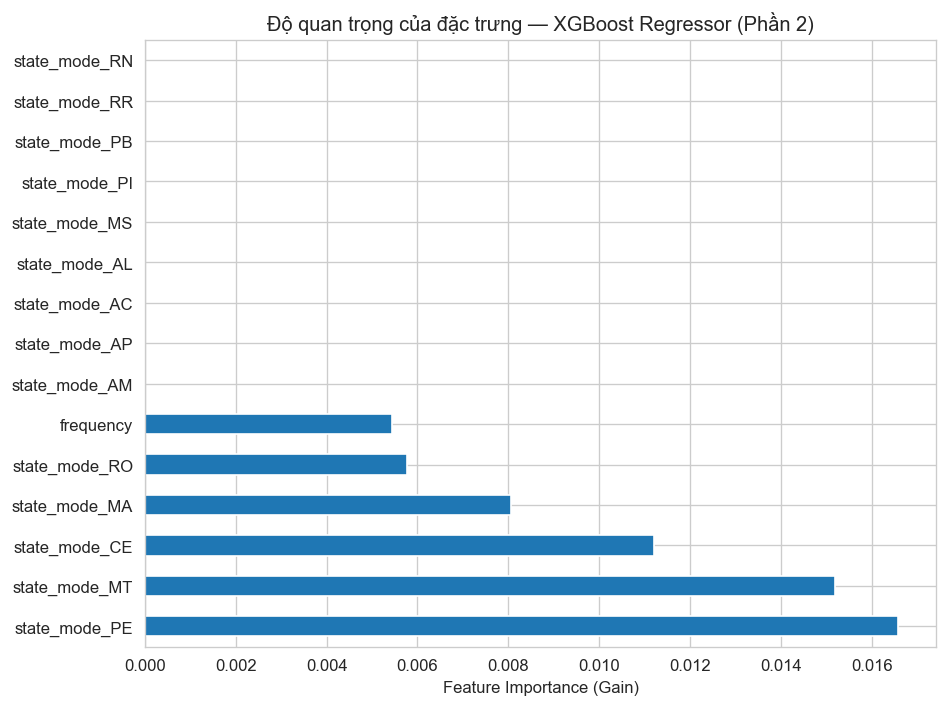

In [111]:
plt.figure(figsize=(8,6))
imp_df.tail(15).plot(kind='barh') # Hiển thị 15 feature quan trọng nhất
plt.title("Độ quan trọng của đặc trưng — XGBoost Regressor (Phần 2)") 
plt.xlabel("Feature Importance (Gain)")
plt.tight_layout()
plt.show()


--- Feature Importance cho Classifier (Phần 1: Dự đoán P(Mua lại)) ---


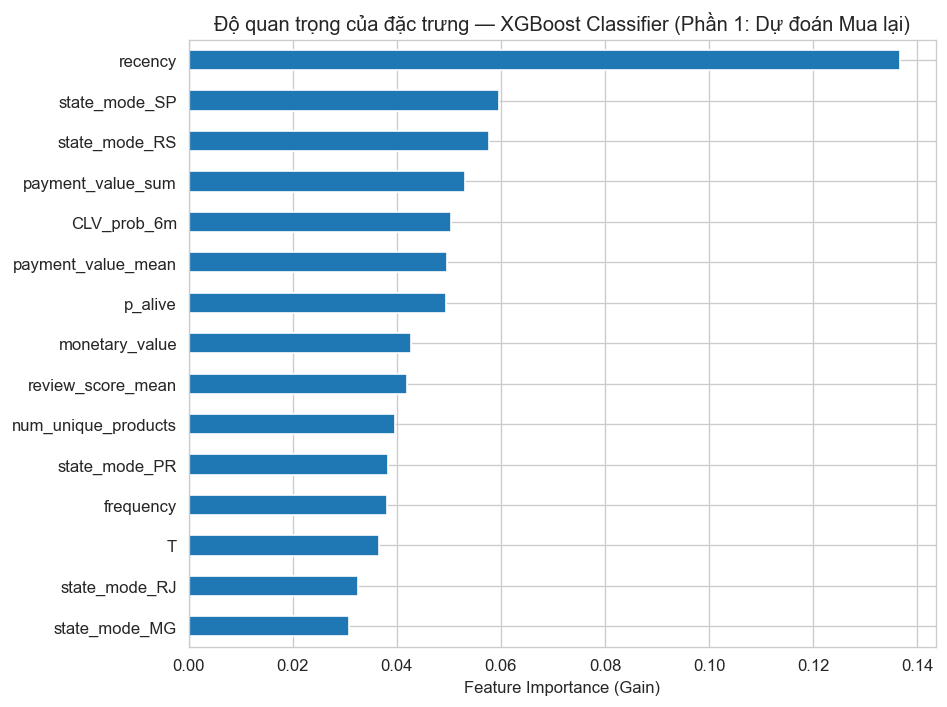


Top 15 Features quan trọng nhất để dự đoán P(Mua lại):
recency                0.136779
state_mode_SP          0.059716
state_mode_RS          0.057688
payment_value_sum      0.053178
CLV_prob_6m            0.050478
payment_value_mean     0.049585
p_alive                0.049365
monetary_value         0.042801
review_score_mean      0.042040
num_unique_products    0.039606
state_mode_PR          0.038375
frequency              0.038168
T                      0.036626
state_mode_RJ          0.032637
state_mode_MG          0.030717
dtype: float32


In [112]:
print("\n--- Feature Importance cho Classifier (Phần 1: Dự đoán P(Mua lại)) ---")

# 1. Lấy tên feature từ preprocessor 
try:
    num_names_cls = numeric_features
    cat_names_cls = list(
        pipe_cls_xgb.named_steps['preprocess']
        .named_transformers_['cat']
        .get_feature_names_out(categorical_features)
    )
    all_feature_names_cls = num_names_cls + cat_names_cls
except Exception as e:
    print(f"Lỗi khi lấy tên feature: {e}")
    all_feature_names_cls = all_feature_names

# 2. Lấy mô hình classifier đã fit từ pipeline 
xgb_cls_model = pipe_cls_xgb.named_steps['model']

# 3. Lấy feature importance
feature_importance_cls = xgb_cls_model.feature_importances_

# 4. Tạo DataFrame và sắp xếp
imp_df_cls = pd.Series(feature_importance_cls, index=all_feature_names_cls).sort_values(ascending=False)

# 5. Vẽ biểu đồ
plt.figure(figsize=(8, 6))
imp_df_cls.head(15).sort_values(ascending=True).plot(kind='barh') # Top 15
plt.title("Độ quan trọng của đặc trưng — XGBoost Classifier (Phần 1: Dự đoán Mua lại)")
plt.xlabel("Feature Importance (Gain)")
plt.tight_layout()
plt.show()

print("\nTop 15 Features quan trọng nhất để dự đoán P(Mua lại):")
print(imp_df_cls.head(15))

## 15.So sánh thực tế vs dự báo & Phân khúc khách hàng

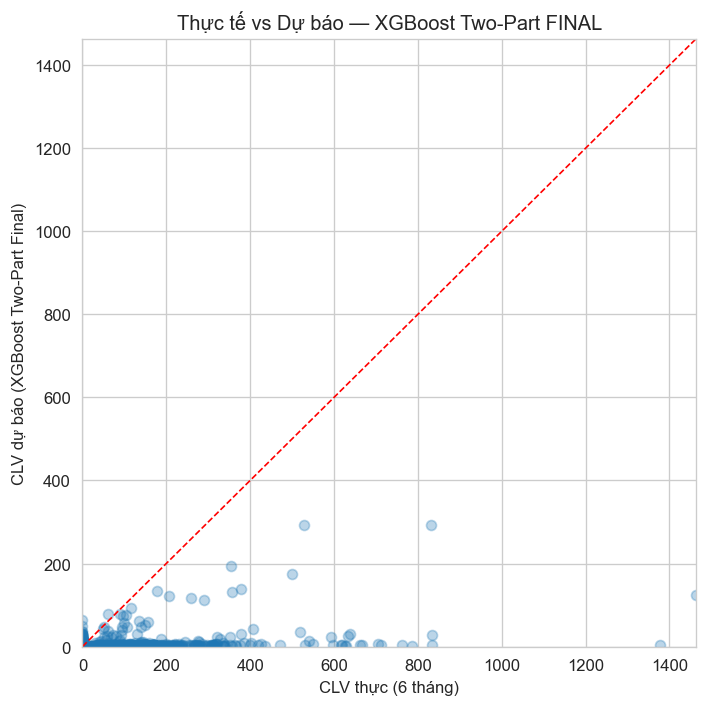

,count,mean,sum
Segment,,,
Low,13882,0.642706,8922.048828
Mid,13881,1.226340,17022.830078
High,14303,2.715881,38845.246094


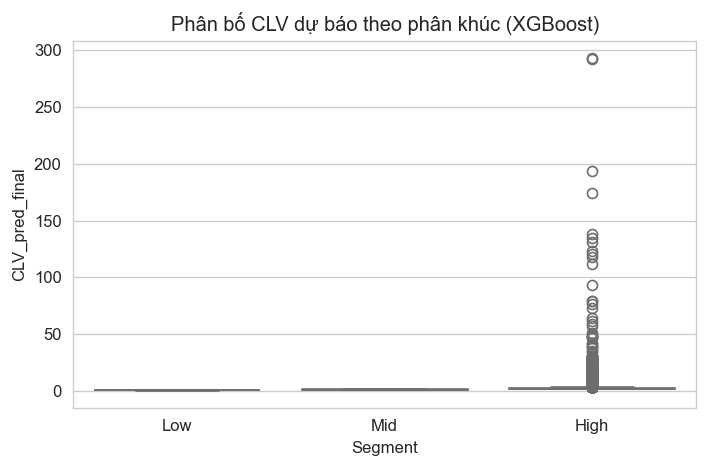

In [113]:
summary_ml['CLV_pred_final'] = np.maximum(y_pred_final, 0)

# --- VẼ SCATTER (THỰC TẾ vs DỰ BÁO) ---
plt.figure(figsize=(6,6))
# (Sử dụng y_actual_final thay vì y_final cũ)
plt.scatter(y_actual_final, y_pred_final, alpha=0.3) 
lim = [0, max(y_actual_final.max(), y_pred_final.max())]
plt.plot(lim, lim, 'r--', linewidth=1)
plt.xlim(lim); plt.ylim(lim)
plt.xlabel('CLV thực (6 tháng)')
plt.ylabel('CLV dự báo (XGBoost Two-Part Final)') 
plt.title('Thực tế vs Dự báo — XGBoost Two-Part FINAL') 
plt.tight_layout(); plt.show()

# --- PHÂN KHÚC THEO QUANTILE 33/66 ---
q33, q66 = np.quantile(summary_ml['CLV_pred_final'], [0.33, 0.66])

def seg(v):
    if v <= q33: return 'Low'
    elif v <= q66: return 'Mid'
    else: return 'High'

summary_ml['Segment'] = summary_ml['CLV_pred_final'].apply(seg)

# Thống kê từng phân khúc
seg_stats = summary_ml.groupby('Segment')['CLV_pred_final'].agg(['count','mean','sum']).sort_values('mean')
display(seg_stats)

# Boxplot CLV theo phân khúc
plt.figure(figsize=(6,4))
sns.boxplot(x='Segment', y='CLV_pred_final', data=summary_ml, palette='coolwarm', order=['Low', 'Mid', 'High'])
plt.title('Phân bố CLV dự báo theo phân khúc (XGBoost)')
plt.tight_layout(); plt.show()

## 16.Xuất CSV kết quả - 3 outputs

In [114]:
import os

# --- Lưu output ---
OUT_DIR = './clv_outputs_final_xgb' 
os.makedirs(OUT_DIR, exist_ok=True)


# 1. Lưu dự đoán chi tiết
out_pred = summary_ml[['customer_unique_id','p_alive','CLV_prob_6m',
                       'CLV_actual_6m','CLV_pred_final','Segment']]
out_pred.to_csv(f'{OUT_DIR}/customer_clv_predictions_xgb.csv', index=False)

# 2. Lưu thống kê phân khúc
seg_stats.to_csv(f'{OUT_DIR}/segment_stats_xgb.csv')

# 3. Lưu tầm quan trọng đặc trưng
imp_df.sort_values(ascending=False).to_csv(f'{OUT_DIR}/xgb_feature_importance.csv')

print("Đã lưu vào thư mục:", OUT_DIR)

Đã lưu vào thư mục: ./clv_outputs_final_xgb


# Phần 2: Đưa ra Insights (dựa theo số liệu và biểu đồ)

## 17. Phân tích Pareto (Two-Part XGBoost)

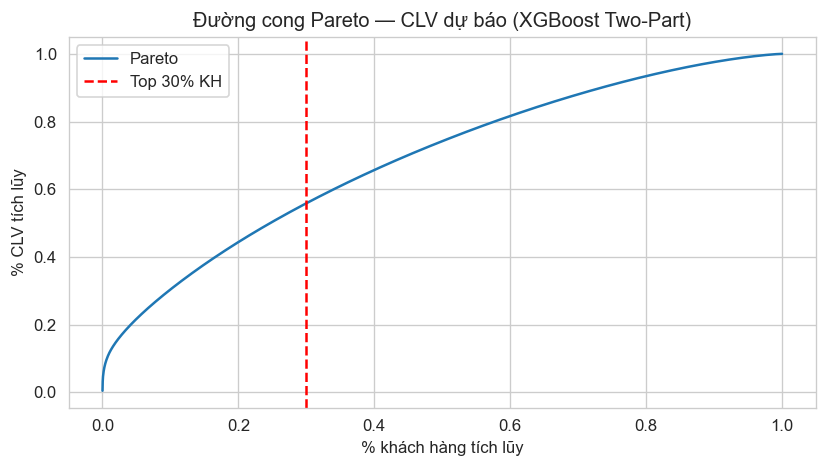

In [115]:
# Sắp xếp và tính toán % tích lũy
srt = summary_ml.sort_values('CLV_pred_final', ascending=False).reset_index(drop=True)
srt['cum_customers'] = (np.arange(len(srt)) + 1) / len(srt)
srt['cum_value'] = srt['CLV_pred_final'].cumsum() / srt['CLV_pred_final'].sum()

# Vẽ biểu đồ
plt.figure(figsize=(7,4))
plt.plot(srt['cum_customers'], srt['cum_value'], label='Pareto')
plt.axvline(0.3, color='r', linestyle='--', label='Top 30% KH')
plt.title('Đường cong Pareto — CLV dự báo (XGBoost Two-Part)')
plt.xlabel('% khách hàng tích lũy')
plt.ylabel('% CLV tích lũy')
plt.legend(); plt.tight_layout(); plt.show()

## 18. Top 10 Khách hàng có CLV cao nhất

In [116]:
# Top 10 khách hàng có CLV cao nhất
top10 = summary_ml.sort_values('CLV_pred_final', ascending=False).head(10)
print("--- Top 10 Khách hàng có CLV dự báo cao nhất (XGBoost) ---")
display(top10[['customer_unique_id','CLV_pred_final','Segment']])

--- Top 10 Khách hàng có CLV dự báo cao nhất (XGBoost) ---


,customer_unique_id,CLV_pred_final,Segment
10244,3e43e6105506432c953e165fb2acf44c,293.667419,High
4911,1da09dd64e235e7c2f29a4faff33535c,292.346405,High
4523,1b6c7548a2a1f9037c1fd3ddfed95f33,193.494751,High
24996,9832ae2f7d3e5fa4c7a1a06e9551bc61,174.016571,High
19031,738ffcf1017b584e9d2684b36e07469c,138.261826,High
16559,6469f99c1f9dfae7733b25662e7f1782,135.025208,High
28403,acea6bd29b8c1e3c6a8b266a8fb4475e,130.910553,High
41807,fe81bb32c243a86b2f86fbf053fe6140,123.280922,High
16466,63cfc61cee11cbe306bff5857d00bfe4,120.725494,High
11431,455c17b35969ca198c17f2fc9e8eba1b,117.870819,High


## 19. Phân tích Biểu đồ Phân khúc (Two-Part XGBoost)

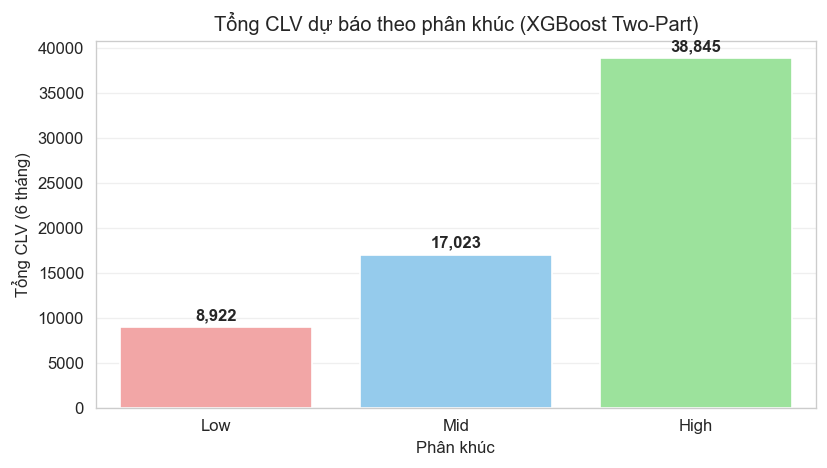

In [117]:
# --- Bar chart tổng CLV theo phân khúc ---
plt.figure(figsize=(7,4))
sns.barplot(x=seg_stats.index, y='sum', data=seg_stats.reset_index(),
            palette=['#FF9999', '#87CEFA', '#90EE90'], order=['Low', 'Mid', 'High']) 
plt.title('Tổng CLV dự báo theo phân khúc (XGBoost Two-Part)') 
plt.ylabel('Tổng CLV (6 tháng)')
plt.xlabel('Phân khúc')

seg_stats_ordered = seg_stats.loc[['Low', 'Mid', 'High']] 
for i, v in enumerate(seg_stats_ordered['sum']): 
    plt.text(i, v + seg_stats_ordered['sum'].max()*0.02, f"{v:,.0f}", ha='center', fontsize=10, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

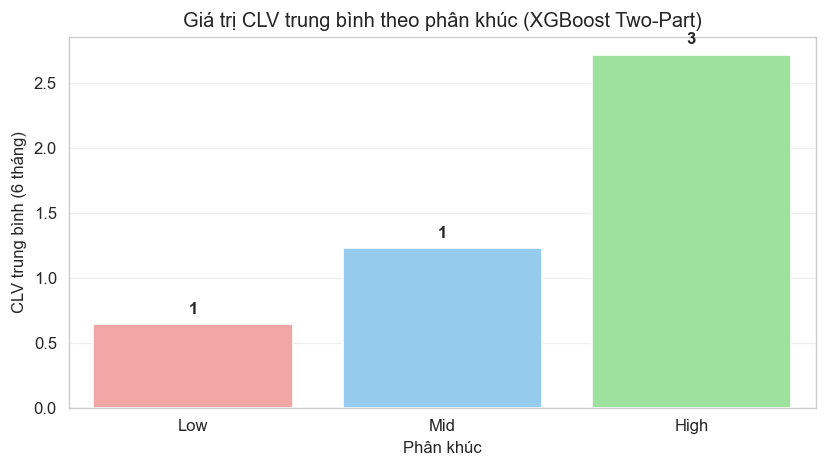

In [118]:
# --- Bar chart trung bình CLV theo phân khúc ---
plt.figure(figsize=(7,4))
sns.barplot(x=seg_stats.index, y='mean', data=seg_stats.reset_index(),
            palette=['#FF9999', '#87CEFA', '#90EE90'], order=['Low', 'Mid', 'High']) 
plt.title('Giá trị CLV trung bình theo phân khúc (XGBoost Two-Part)') 
plt.ylabel('CLV trung bình (6 tháng)')
plt.xlabel('Phân khúc')

seg_stats_ordered = seg_stats.loc[['Low', 'Mid', 'High']]
for i, v in enumerate(seg_stats_ordered['mean']):
    plt.text(i, v + seg_stats_ordered['mean'].max()*0.03, f"{v:,.0f}", ha='center', fontsize=10, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

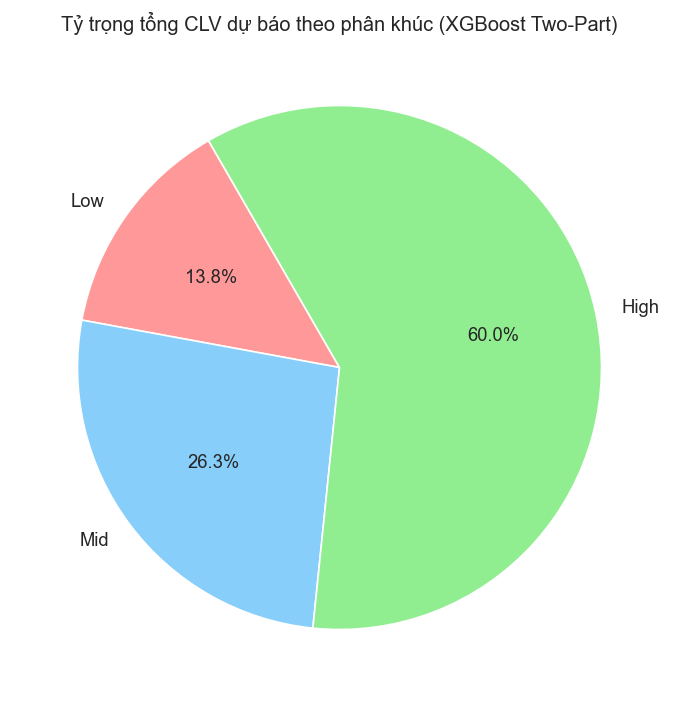

In [119]:
# --- Pie chart thể hiện tỉ trọng tổng CLV ---
plt.figure(figsize=(6,6))
colors = ['#FF9999', '#87CEFA', '#90EE90']
plt.pie(seg_stats['sum'], labels=seg_stats.index, autopct='%1.1f%%',
        startangle=120, colors=colors, textprops={'fontsize':11})
plt.title('Tỷ trọng tổng CLV dự báo theo phân khúc (XGBoost Two-Part)')
plt.tight_layout()
plt.show()

In [120]:
out_pred = pd.read_csv(f"{OUT_DIR}/customer_clv_predictions_xgb.csv") 

# Tính toán Pareto
clv = out_pred["CLV_pred_final"].clip(lower=0)
out_pred = out_pred.assign(_clv=clv).sort_values("_clv", ascending=False).reset_index(drop=True)
out_pred["cum_cust_pct"] = (np.arange(len(out_pred)) + 1) / len(out_pred)
out_pred["cum_clv"] = out_pred["_clv"].cumsum()
total_clv = out_pred["_clv"].sum()
out_pred["cum_clv_pct"] = out_pred["cum_clv"] / total_clv

# In ra các mốc % CLV
print("--- Báo cáo Phân bổ Pareto (XGBoost Two-Part) ---")
for t in [0.5, 0.7, 0.8, 0.9]:
    try:
        share = out_pred.loc[out_pred["cum_clv_pct"] >= t, "cum_cust_pct"].iloc[0]
        print(f"{int(t*100)}% tổng CLV đạt được bởi {share:.1%} khách hàng")
    except IndexError:
        print(f"Không đạt được mốc {int(t*100)}% CLV.")

--- Báo cáo Phân bổ Pareto (XGBoost Two-Part) ---
50% tổng CLV đạt được bởi 24.7% khách hàng
70% tổng CLV đạt được bởi 44.9% khách hàng
80% tổng CLV đạt được bởi 57.7% khách hàng
90% tổng CLV đạt được bởi 73.4% khách hàng


In [121]:
seg_stats_table = pd.read_csv(f"{OUT_DIR}/segment_stats_xgb.csv")
seg_stats_table.rename(columns=str.lower, inplace=True)

# Tính tỷ lệ KH và CLV
seg_stats_table["share_customers"] = seg_stats_table["count"] / seg_stats_table["count"].sum()
seg_stats_table["share_clv"] = seg_stats_table["sum"] / seg_stats_table["sum"].sum()

# Làm tròn & định dạng bảng
seg_stats_table["share_customers_fmt"] = (seg_stats_table["share_customers"]*100).round(0).astype(int).astype(str).radd("~").add("%")
seg_stats_table["share_clv_fmt"] = (seg_stats_table["share_clv"]*100).round(0).astype(int).astype(str).radd("~").add("%")
table = seg_stats_table[["segment", "share_customers_fmt", "share_clv_fmt"]]
table.columns = ["Phân khúc", "Tỷ lệ khách hàng", "Tỷ lệ CLV"]

print("\n Phân khúc khách hàng theo CLV (XGBoost Two-Part):")
print(table.to_string(index=False))


 Phân khúc khách hàng theo CLV (XGBoost Two-Part):
Phân khúc Tỷ lệ khách hàng Tỷ lệ CLV
      Low             ~33%      ~14%
      Mid             ~33%      ~26%
     High             ~34%      ~60%


In [122]:
n_customers = len(out_pred)
mean_clv = out_pred["_clv"].mean()
median_clv = out_pred["_clv"].median()
p95_clv = out_pred["_clv"].quantile(0.95)
try:
    share_80pct = out_pred.loc[out_pred["cum_clv_pct"] >= 0.8, "cum_cust_pct"].iloc[0]
    share_80_text = f"- Top {share_80pct*100:.1f}% khách hàng nắm giữ 80% tổng CLV dự báo."
except IndexError:
    share_80_text = "- (Không đạt mốc 80% CLV)"


print("\n Tóm tắt nhanh insight mô hình CLV (XGBoost Two-Part):") 
print(f"- Số khách hàng: {n_customers:,}")
print(f"- CLV trung bình: {mean_clv:,.2f}")
print(f"- CLV trung vị: {median_clv:,.2f}")
print(f"- CLV 95th percentile: {p95_clv:,.2f}")
print(share_80_text)


 Tóm tắt nhanh insight mô hình CLV (XGBoost Two-Part):
- Số khách hàng: 42,066
- CLV trung bình: 1.54
- CLV trung vị: 1.22
- CLV 95th percentile: 3.01
- Top 57.7% khách hàng nắm giữ 80% tổng CLV dự báo.
